# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Шаг 1: Загружаем данные.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, make_scorer
from collections import defaultdict

In [2]:
data_0 = pd.read_csv('geo_data_0.csv')
data_1 = pd.read_csv('geo_data_1.csv')
data_2 = pd.read_csv('geo_data_2.csv')

In [3]:
display(data_0.head(10))
print()
display(data_1.head(10))
print()
display(data_2.head(10))

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


Данные загрузились корректно, теперь посмотрим о них общую информацию.

In [4]:
data_0.info()
print()
data_1.info()
print()
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Nul

Объём данных достаточно большой, в каждом файле 5 столбцов по 100000 строчек.

Теперь проверим данные на наличие пропусков.

In [5]:
print(data_0.isna().sum())
print()
print(data_1.isna().sum())
print()
print(data_2.isna().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Данные подготовлены очень хорошо, в них нет ни одного пропуска. прверим дубликаты.

In [6]:
print(data_0['id'].duplicated().sum())
print()
print(data_1['id'].duplicated().sum())
print()
print(data_2['id'].duplicated().sum())

10

10

10


In [7]:
data_0['id'].drop_duplicates()
data_1['id'].drop_duplicates()
data_2['id'].drop_duplicates()

0        txEyH
1        2acmU
2        409Wp
3        iJLyR
4        Xdl7t
         ...  
99995    DLsed
99996    QKivN
99997    3rnvd
99998    7kl59
99999    1CWhH
Name: id, Length: 99990, dtype: object

In [8]:
print(data_0.duplicated().sum())
print()
print(data_1.duplicated().sum())
print()
print(data_2.duplicated().sum())

0

0

0


Дубликатов в данных тоже нет, это хорошо.

In [9]:
cm = sns.light_palette("pink", as_cmap=True)

data_0.corr().style.background_gradient(cmap=cm)

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [10]:
data_1.corr().style.background_gradient(cmap=cm)


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [11]:
data_2.corr().style.background_gradient(cmap=cm)


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


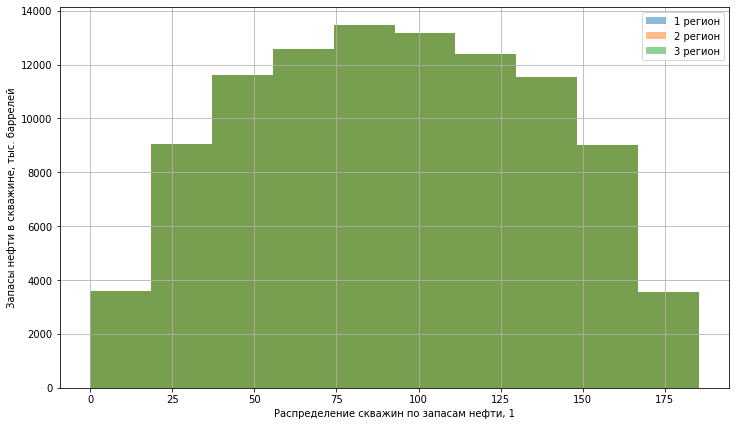

In [12]:
pr0 = data_0['product'].plot(kind='hist',
                             figsize=(12,7),
                             grid=True,
                             legend=True,
                             alpha=0.5,
                             label='1 регион');
pr1 = data_1['product'].plot(kind='hist',
                             figsize=(12,7),
                             grid=True,
                             legend=True,
                             alpha=0.5,
                             label='2 регион');
pr2 = data_2['product'].plot(kind='hist',
                             figsize=(12,7),
                             grid=True,
                             legend=True,
                             alpha=0.5,
                             label='3 регион');
plt.xlabel('Распределение скважин по запасам нефти, 1');
plt.ylabel('Запасы нефти в скважине, тыс. баррелей');

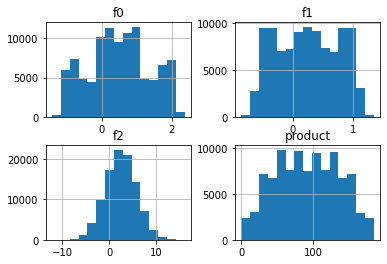

In [13]:
data_0.hist(bins=15);

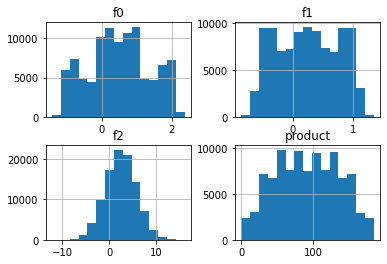

In [30]:
data_1.hist(bins=15);

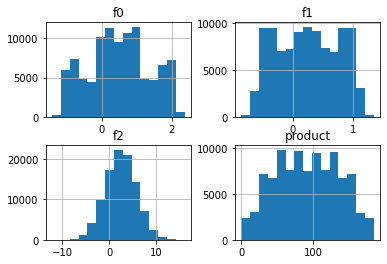

In [31]:
data_2.hist(bins=15);

Прямая корреляция очень близка к 1 во втором регионе (связь принзнака f1 и product).

В принципе, на мой взгляд, нет каких-то явных пробелов в данных, поэтому можем идти дальше.

In [14]:
#удалим колонку с id, т.к. она не несет для нас смысловой нагрузки
#и в дальнейшем она может вызвать ошибки при обучении
data_0 = data_0.drop(columns = ['id'])
data_1 = data_1.drop(columns = ['id'])
data_2 = data_2.drop(columns = ['id'])

## Обучение и проверка модели

In [15]:
#разобьем данные на обучающие и на валидационные выборки
features_0 = data_0.drop(['product'], axis=1)
features_1 = data_1.drop(['product'], axis=1)
features_2 = data_2.drop(['product'], axis=1)
target_0 = data_0['product']
target_1 = data_1['product']
target_2 = data_2['product']

features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split( 
    features_0, target_0, test_size=0.25, random_state=12345)

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split( 
    features_1, target_1, test_size=0.25, random_state=12345)

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split( 
    features_2, target_2, test_size=0.25, random_state=12345)

In [16]:
#обучим модель по тренировочной выборке первого региона
#посмотрим на среднеквадратичное отклонение предсказания
model_0 = LinearRegression()
model_0.fit(features_train_0, target_train_0)
predict_0 = model_0.predict(features_valid_0)
rmse_0 = mean_squared_error(target_valid_0, predict_0)**0.5
print('Среднеквадратичное отклонение равно: %.2f' % rmse_0)
result_0 = model_0.score(features_valid_0, target_valid_0)
print('Точность модели равнf: {:.2%}'.format(result_0))

Среднеквадратичное отклонение равно: 37.58
Точность модели равнf: 27.99%


In [17]:
#обучим модель по тренировочной выборке второго региона
#посмотрим на среднеквадратичное отклонение предсказания
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)
predict_1 = model_1.predict(features_valid_1)
rmse_1 = mean_squared_error(target_valid_1, predict_1)**0.5
print('Среднеквадратичное отклонение равно: %.2f' % rmse_1)
result_1 = model_1.score(features_valid_1, target_valid_1)
print('Точность модели равна: {:.2%}'.format(result_1))

Среднеквадратичное отклонение равно: 37.58
Точность модели равна: 27.99%


In [18]:
#обучим модель по тренировочной выборке третьего региона
#посмотрим на среднеквадратичное отклонение предсказания
model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)
predict_2 = model_2.predict(features_valid_2)
rmse_2 = mean_squared_error(target_valid_2, predict_2)**0.5
print('Среднеквадратичное отклонение равно: %.2f' % rmse_2)
result_2 = model_2.score(features_valid_2, target_valid_2)
print('Точность модели равна: {:.2%}'.format(result_2))

Среднеквадратичное отклонение равно: 37.58
Точность модели равна: 27.99%


Предсказания сделанные по валидационным признакам хранятся в переменных predict_0, predict_1, predict_2. Правильные валидационные данные хранятся в переменных target_valid_0, target_valid_1, target_valid_2.

Как мы видим из расчетов - модель обученная по втрому региону обладает большей точностью, и меньшей среднеквадратичной ошибкой. Скорее всего это связано с тем что данные, на которых обучалась модель, имеют малый разброс.

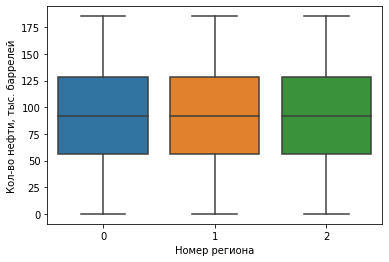

In [19]:
sns.boxplot(data=[data_0['product'], data_1['product'], data_2['product']])
#rcParams['figure.figsize'] = 5, 10
plt.xlabel('Номер региона')
plt.ylabel('Кол-во нефти, тыс. баррелей')
plt.show()

Как мы видим из графика, действительно - во 2 регионе разброс данных меньше, чем в друх других.

И так... Модели обучены, предсказания сделаны.

## Подготовка к расчёту прибыли

Бюджет на разработку скважин в регионе — 10 млрд рублей. (budget)
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей. (barrel_cost)
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью. probability_of_losses

In [20]:
#для всех ключевых значений созданы константы Python
budget = 10_000_000_000
barrel_cost = 450_000
probability_of_losses = 0.025
top_200 = 200

In [21]:
budget_for_one = budget/top_200
budget_for_one

50000000.0

Поскольку перед нами стоит задача на разработку 200 скважин в регионе - значит на разработку каждой скважины требуется 50 млн. (budget_for_one)

Таким образом можно сказать, что для разработки подходят скважины, имеющие нефть, суммарная стоимость которой превышает 50 млн. руб.

In [22]:
print('Средний объем нефти в 1 регионе', data_0['product'].mean())
print('Средний объем нефти в 2 регионе', target_1.mean())
print('Средний объем нефти в 3 регионе', target_2.mean())

Средний объем нефти в 1 регионе 92.50000000000001
Средний объем нефти в 2 регионе 92.50000000000001
Средний объем нефти в 3 регионе 92.50000000000001


In [23]:
min_barrel_need = budget_for_one/barrel_cost
min_barrel_need

111.11111111111111

Из расчета видно что минимальное достаточное количество нефти для окупаемости скважины равно 111 тыс. баррелей нефти.

Средний объем нефти в регионах ниже, чем необходимый для безубыточной разработки.

Ранее была показана диаграмма разброса (ящик с усами), на котором виден диапазон разброса значений количества нефти в регионах. Поэтому нельзя сказать что регионы будут 100% убыточны при разработке лишь 200 скважин, а не всего региона.

Расчет прибыли региона будет высчитываться по формуле:

прибыль = кол-во тыс. баррелей добытых в регионе стоимость 1 тыс. баррелей - бюджет затраченный на разработку скважин в регионе*

In [24]:
def profit(target_valid, predictions_valid, top_200):
    
    target = target_valid.reset_index(drop = True)
    predictions = pd.Series(predictions_valid, index = target.index)
    best_points = target[predictions.sort_values(ascending = False).index][:top_200]
    
    return (best_points.sum() * barrel_cost - budget) / 1000000

## Расчёт прибыли и рисков 

Отсортируем предсказания по убыванию, таким образом чтобы первые 200 значений были самыми большими из них (предсказаний).

Посчитаем суммарное кол-во нефти в них и прибыль которую они могу принести.

In [25]:
#predict_0.sorted()
#predict_0

sum_bar_0 = predict_0[:200].sum()
sum_bar_1 = predict_1[:200].sum()
sum_bar_2 = predict_2[:200].sum()

print('Объем нефти в 1 регионе равен %.0f' % sum_bar_0, 'тыс. баррелей')
print('Объем нефти в 1 регионе равен %.0f' % sum_bar_1, 'тыс. баррелей')
print('Объем нефти в 1 регионе равен %.0f' % sum_bar_2, 'тыс. баррелей')

Объем нефти в 1 регионе равен 18260 тыс. баррелей
Объем нефти в 1 регионе равен 18260 тыс. баррелей
Объем нефти в 1 регионе равен 18260 тыс. баррелей


Если я правильно понял, то вероятность убытка это отношение количества значений прибыли (count), ко всем (1000 выборок).

In [26]:
def bootstrap1000(target, predict, n):
    state = np.random.RandomState(12345)
    profits = []
    count = 0

    for i in range(1000):
        target_subsample = target.reset_index(drop= True).sample(n, random_state=state, replace=True)
        probs_subsample = predict[target_subsample.index]
        #сортируем список по запасам нефти
        profits.append(profit(target_subsample,
                              probs_subsample, top_200))#заполняем прибыть
    profits = pd.Series(profits)
    
    count = profits[profits<0].count()/1000

    lower = profits.quantile(0.025)
    upper = profits.quantile(.975)

    print('Средняя прибыль в регионе равна: %.2f' % (profits.mean()), 'мл. руб.')
    print('95% доверительный интервал лежит в диапазоне: {:.2f}'.format(lower),
          '- {:.2f}'.format(upper))
    print('Вероятность убытка равна: {:.2%}'.format(count))

Для первого региона:

In [27]:
bootstrap1000(target_valid_0, predict_0, 500)

Средняя прибыль в регионе равна: 396.16 мл. руб.
95% доверительный интервал лежит в диапазоне: -111.22 - 909.77
Вероятность убытка равна: 6.90%


Для второго региона:

In [28]:
bootstrap1000(target_valid_1, predict_1, 500)

Средняя прибыль в регионе равна: 396.16 мл. руб.
95% доверительный интервал лежит в диапазоне: -111.22 - 909.77
Вероятность убытка равна: 6.90%


Для третьего региона:

In [29]:
bootstrap1000(target_valid_2, predict_2, 500)

Средняя прибыль в регионе равна: 396.16 мл. руб.
95% доверительный интервал лежит в диапазоне: -111.22 - 909.77
Вероятность убытка равна: 6.90%


# Вывод
Подготовил данные. Проверил на наличие дубликатов, пропусков, посмотрел форматы данных. Изучили данные.
Разбил данные на обучающую и валидационную выборку. Обучил модель.
Рассчитал среднеквадратичное отклонение предсказаний от валидационной выборки
Написал функции расчета прибыли и Bootstrap
Сравнил средний объем нефти в регионе с минимальным объемом при котором разработка скважины окупала бы сама себя (расстроился, в среднем во всех регионах этот показатель ниже, чем хотелось бы)
Посмотрел на разброс объемов нефти в скважинах, в 1 регионе он ощутимо ниже
Процедурой Bootstrap разбил выборки по 500 значений, из этих 500, сортировкой, взял 200 с наибольшим показателем объема в скважине. Расчитал суммарный доход, вычел из него бюджет затраченный на разработку - получил прибыль (или убыток, если значение отрицательное). И так 1000 раз...
Взял отношение количества значений убытка ко всех значениям (1000 группировок)
Расчитал среднюю прибыль в регионе, доверительный интервал и вероятность убытка (порядок действий описал выше)

Подводя итог могу сказать, что наимее потенциально убыточно было бы вложить бюджет в развитие добычи во 2 регионе, т.к там самая низкая вероятность убытка, при этом самая высокая средняя прибыль.